### 데이터 구성 <br>
#### data_raw 폴더 아래에
- {name}_OHLCV.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 일별 데이터
- 첫 행 : Date, Close, High, Low, Open, Volume, Ticker
- 둘째 행 : , GLD, GLD, GLD, GLD, GLD

#### monthly_return 폴더 아래에
- {name}_monthly_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 리턴 (월간 수익률) 데이터
- 첫 행 : Date, Monthly Return

#### data_monthly 폴더 아래에
- {name}_monthly.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 가격 (월간 종가) 데이터
- 첫 행 : Date, Monthly Close

#### dividend_data 폴더 아래에
- {name}_dividends.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT 존재 (GLD는 없음)
- 배당 데이터
- 첫 행 : Date, Dividend

#### total_return 폴더 아래에
- {name}_total_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 배당 재투자 반영한 누적 수익률 데이터
- 첫 행 : Date, Monthly Return, Monthly Close, Dividend Yield, Total Return, Cumulative Return

# 1. 데이터 로딩 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# seaborn 스타일 설정
sns.set_style('whitegrid')
sns.set_context('talk')

# 종목 리스트
tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 폴더 경로
data_raw_path = './data_raw'
monthly_return_path = './monthly_return'
data_monthly_path = './data_monthly'
dividend_data_path = './dividend_data'
total_return_path = './total_return'

# 1) 일별 OHLCV 데이터 읽기
ohlcv_dfs = {}
for t in tickers:
    file = os.path.join(data_raw_path, f"{t}_OHLCV.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    ohlcv_dfs[t] = df

# 2) 월별 가격(종가) 데이터 읽기
monthly_close_dfs = {}
for t in tickers:
    file = os.path.join(data_monthly_path, f"{t}_monthly.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_close_dfs[t] = df

# 3) 월별 수익률 데이터 읽기
monthly_return_dfs = {}
for t in tickers:
    file = os.path.join(monthly_return_path, f"{t}_monthly_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_return_dfs[t] = df

# 4) 배당 데이터 (GLD 없음)
dividend_dfs = {}
for t in ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT']:
    file = os.path.join(dividend_data_path, f"{t}_dividends.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    dividend_dfs[t] = df

# 5) 배당 재투자 누적 수익률 데이터
total_return_dfs = {}
for t in tickers:
    file = os.path.join(total_return_path, f"{t}_total_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    total_return_dfs[t] = df

# 2. 개별 종목의 월별 수익률 합치기

In [5]:
# 개별 종목 월별 수익률 합치기
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 3. 그래프 그리기 : 막대 그래프

## 3-1. 10-year Rolling Returns 분포
- ex. QQQ : -10.0% ~ 25.0% 범위를 2.5% 단위로 나누고 각 범위별 rolling returns 분포를 세로축(0~40%)에 표시하기

In [11]:
import itertools
import pandas as pd
import numpy as np

tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']
combinations = list(itertools.combinations(tickers, 2))
window = 120  # 10년 (120개월)

# 최저 수익률 저장 변수 초기화
overall_min_return = float('inf')
overall_min_date = None
overall_min_combo = None

for combo in combinations:
    portfolio_return = indiv_returns_df[list(combo)].mean(axis=1)

    rolling_returns = []
    dates = []
    for i in range(len(portfolio_return) - window):
        window_returns = portfolio_return.iloc[i:i + window]
        total_return = (1 + window_returns).prod()
        annualized_return = total_return ** (1 / 10) - 1
        rolling_returns.append(annualized_return * 100)
        dates.append(portfolio_return.index[i + window])

    df_roll = pd.DataFrame({'Date': dates, '10Y_Annual_Return (%)': rolling_returns})
    
    min_idx = df_roll['10Y_Annual_Return (%)'].idxmin()
    min_return = df_roll.loc[min_idx, '10Y_Annual_Return (%)']
    min_date = df_roll.loc[min_idx, 'Date']

    if min_return < overall_min_return:
        overall_min_return = min_return
        overall_min_date = min_date
        overall_min_combo = combo

print(f"전체 조합 중 최저 10년 연 복리 수익률: {overall_min_return:.2f}%")
print(f"최저 수익률 조합: {overall_min_combo[0]} + {overall_min_combo[1]}")
print(f"최저 수익률 시점(끝나는 달): {overall_min_date.strftime('%Y-%m')}")

전체 조합 중 최저 10년 연 복리 수익률: -8.35%
최저 수익률 조합: QQQ + TLT
최저 수익률 시점(끝나는 달): 2010-03


In [13]:
import pandas as pd
import numpy as np

tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']
window = 120  # 10년 (120개월)

overall_min_return = float('inf')
overall_min_date = None
overall_min_ticker = None

for ticker in tickers:
    returns = indiv_returns_df[ticker]

    rolling_returns = []
    dates = []
    for i in range(len(returns) - window):
        window_returns = returns.iloc[i:i + window]
        total_return = (1 + window_returns).prod()
        annualized_return = total_return ** (1 / 10) - 1
        rolling_returns.append(annualized_return * 100)
        dates.append(returns.index[i + window])

    df_roll = pd.DataFrame({'Date': dates, '10Y_Annual_Return (%)': rolling_returns})

    min_idx = df_roll['10Y_Annual_Return (%)'].idxmin()
    min_return = df_roll.loc[min_idx, '10Y_Annual_Return (%)']
    min_date = df_roll.loc[min_idx, 'Date']
    print(f"{ticker} 최저 10년 연 복리 수익률: {min_return:.2f}%, 시점: {min_date.strftime('%Y-%m')}")

    if min_return < overall_min_return:
        overall_min_return = min_return
        overall_min_date = min_date
        overall_min_ticker = ticker

print(f"\n전체 종목 중 최저 10년 연 복리 수익률은 {overall_min_return:.2f}%이며,")
print(f"종목명: {overall_min_ticker}, 시점: {overall_min_date.strftime('%Y-%m')}")

JEPI 최저 10년 연 복리 수익률: -0.05%, 시점: 2020-07
QQQ 최저 10년 연 복리 수익률: -8.06%, 시점: 2010-03
SCHD 최저 10년 연 복리 수익률: 0.00%, 시점: 2008-02
SPY 최저 10년 연 복리 수익률: -3.45%, 시점: 2009-03
TLT 최저 10년 연 복리 수익률: -2.01%, 시점: 2025-02
GLD 최저 10년 연 복리 수익률: -1.05%, 시점: 2022-10

전체 종목 중 최저 10년 연 복리 수익률은 -8.06%이며,
종목명: QQQ, 시점: 2010-03


In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 음수 부호 깨짐 방지 (optional)
plt.rcParams['axes.unicode_minus'] = False

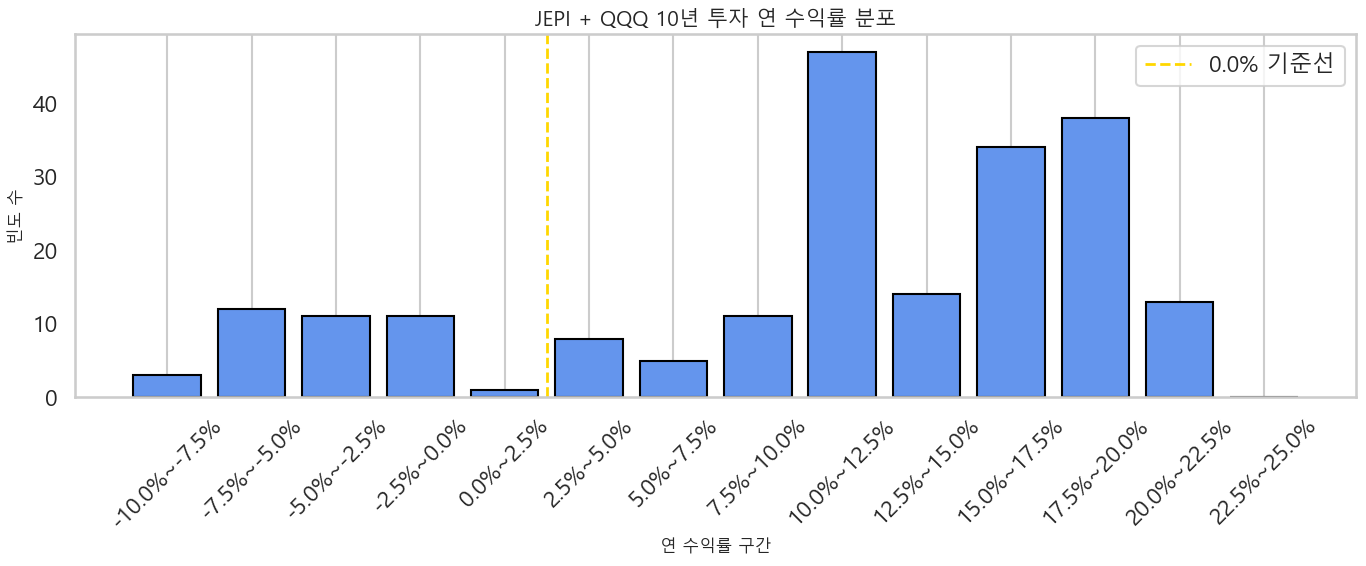

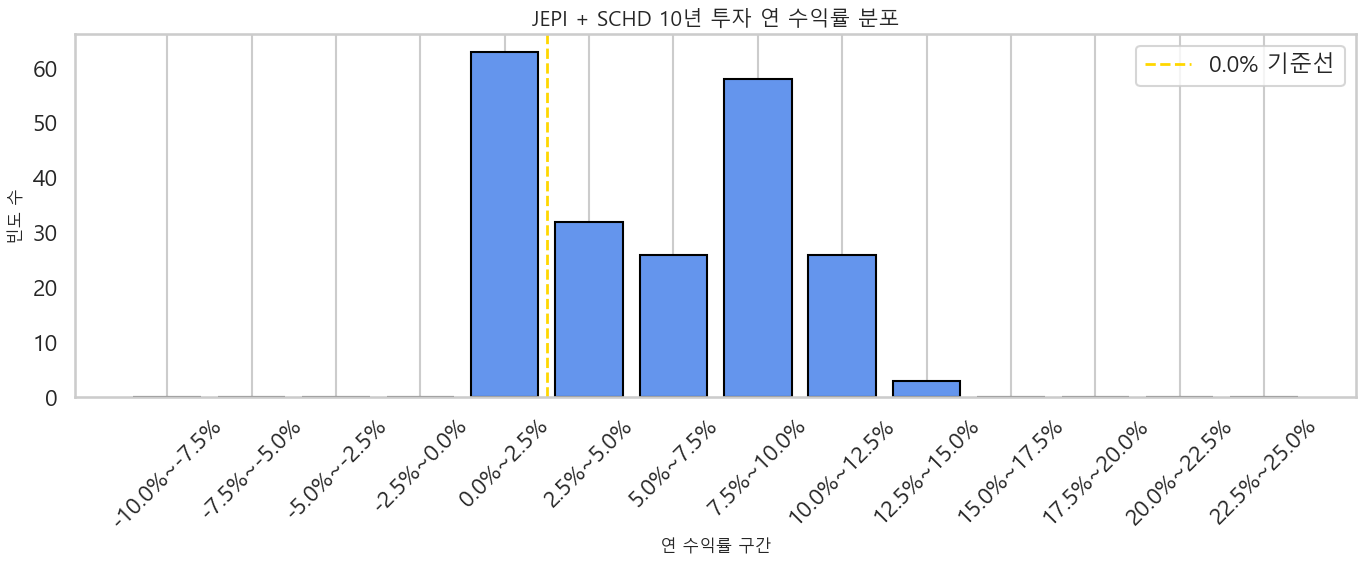

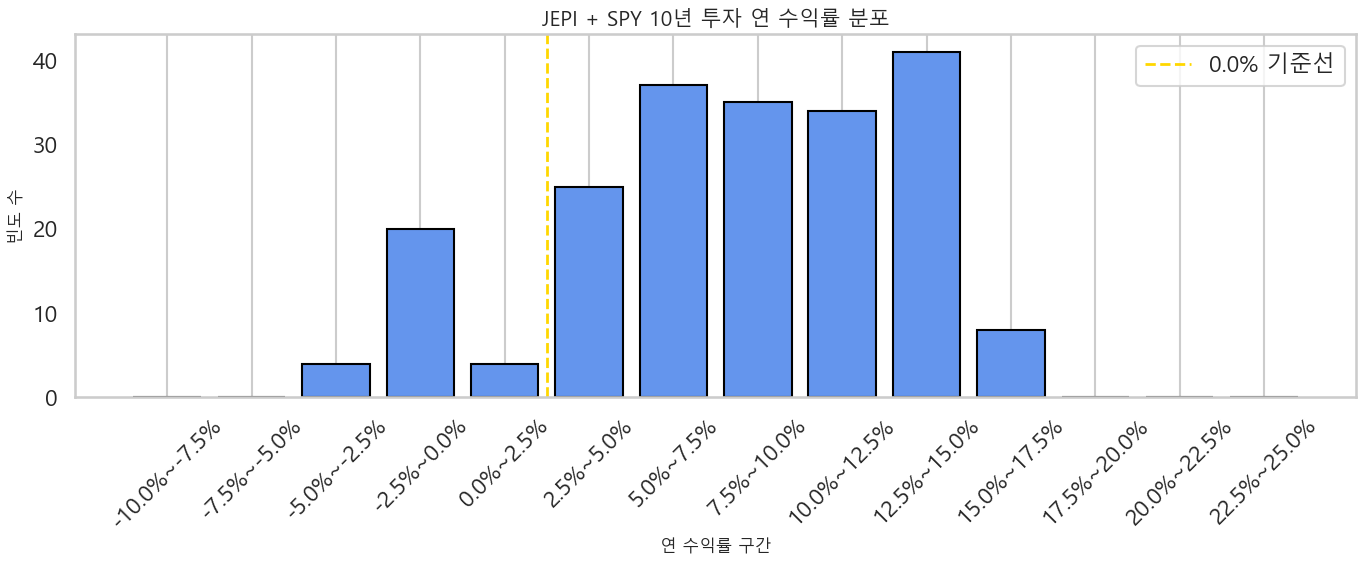

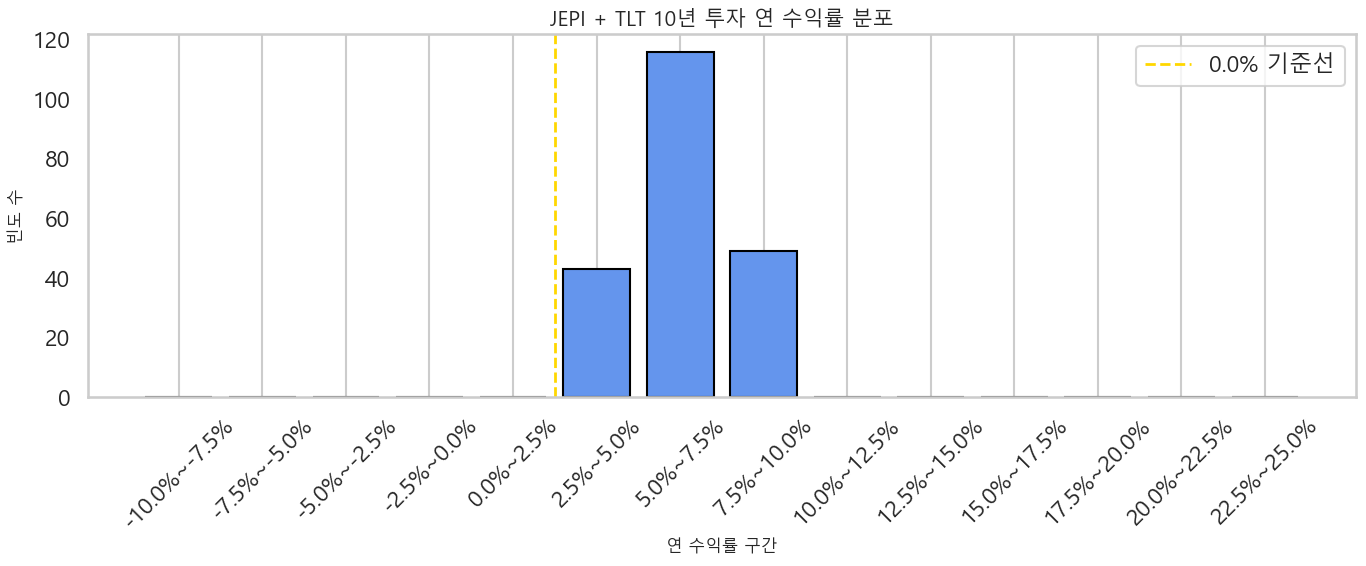

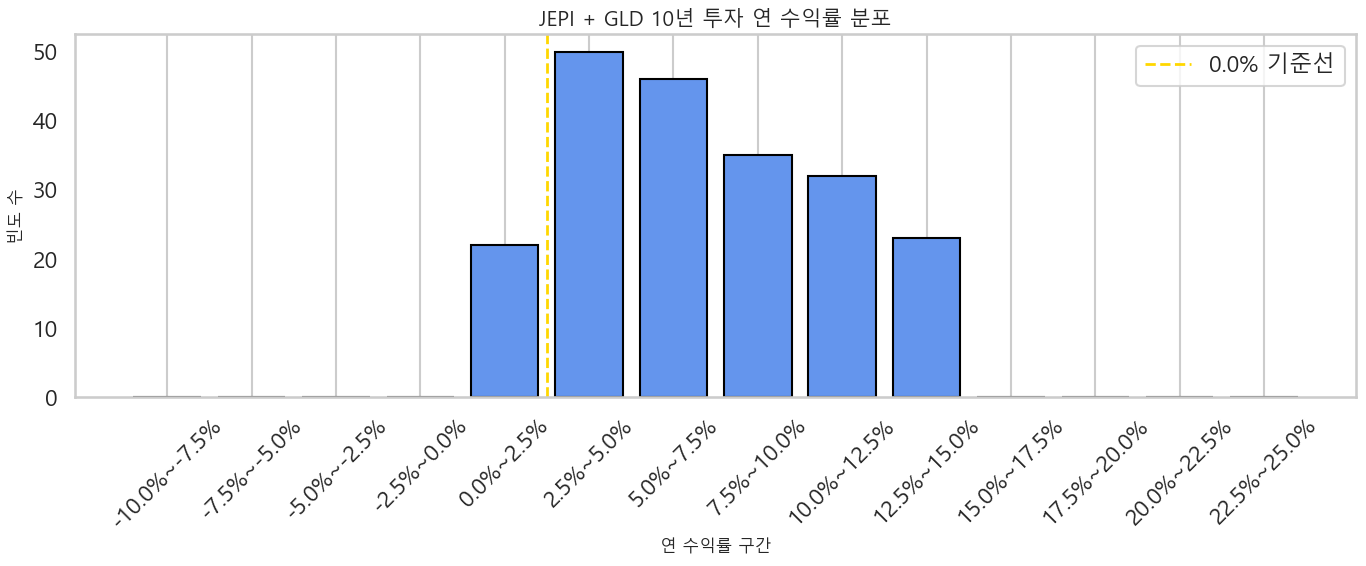

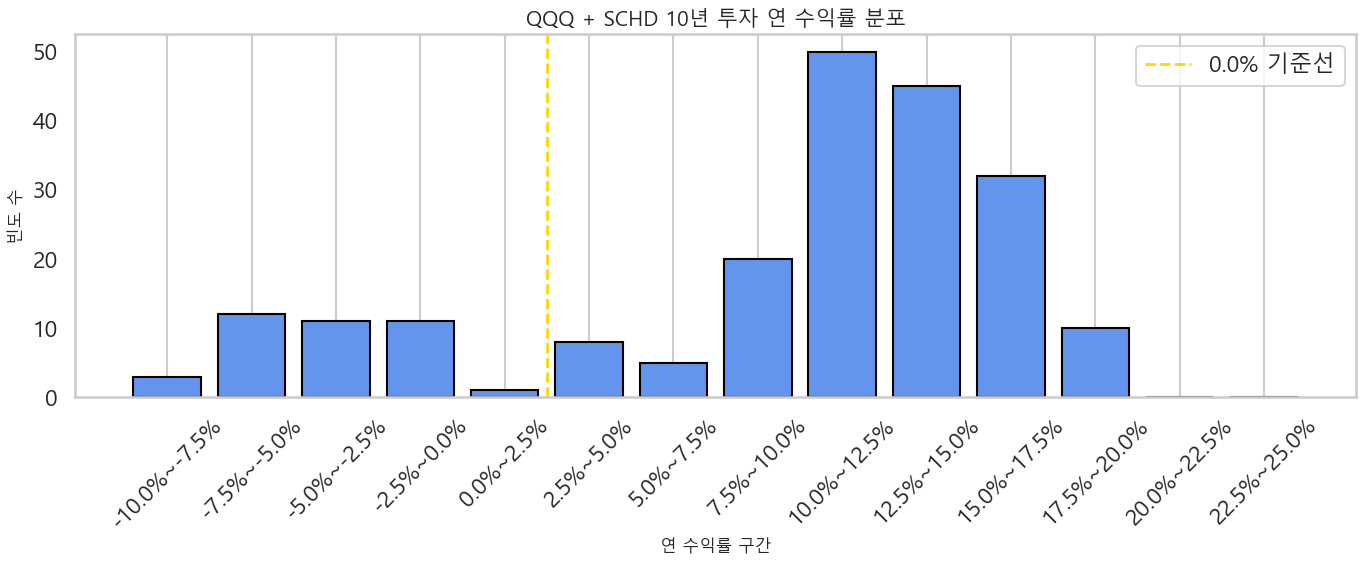

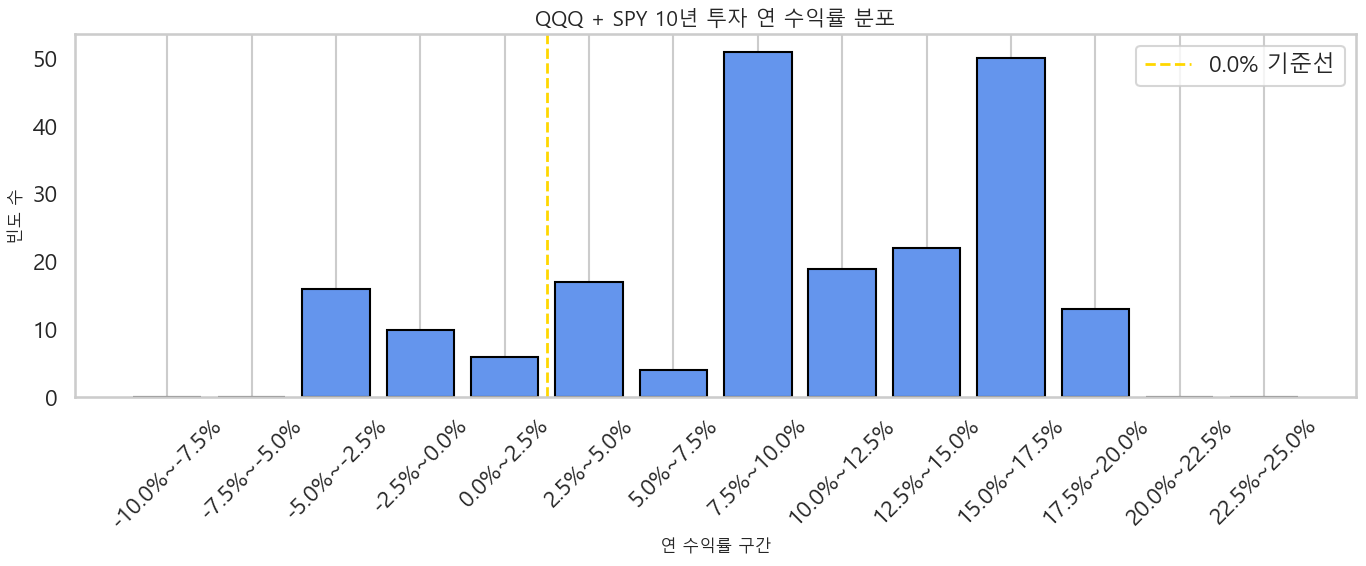

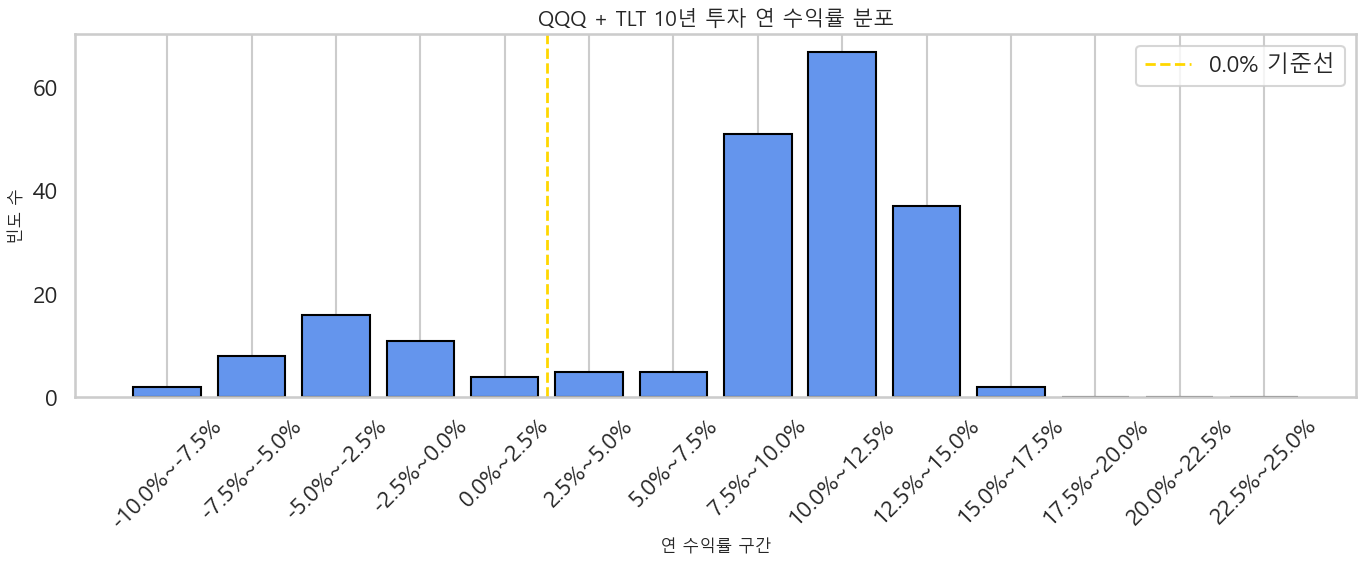

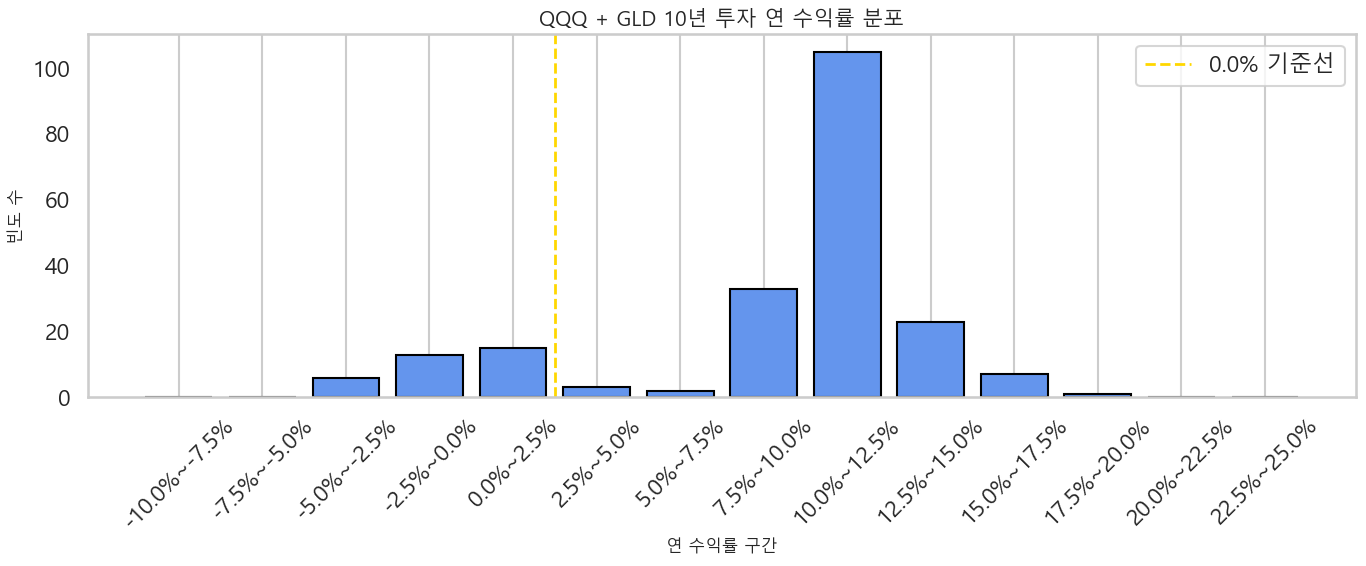

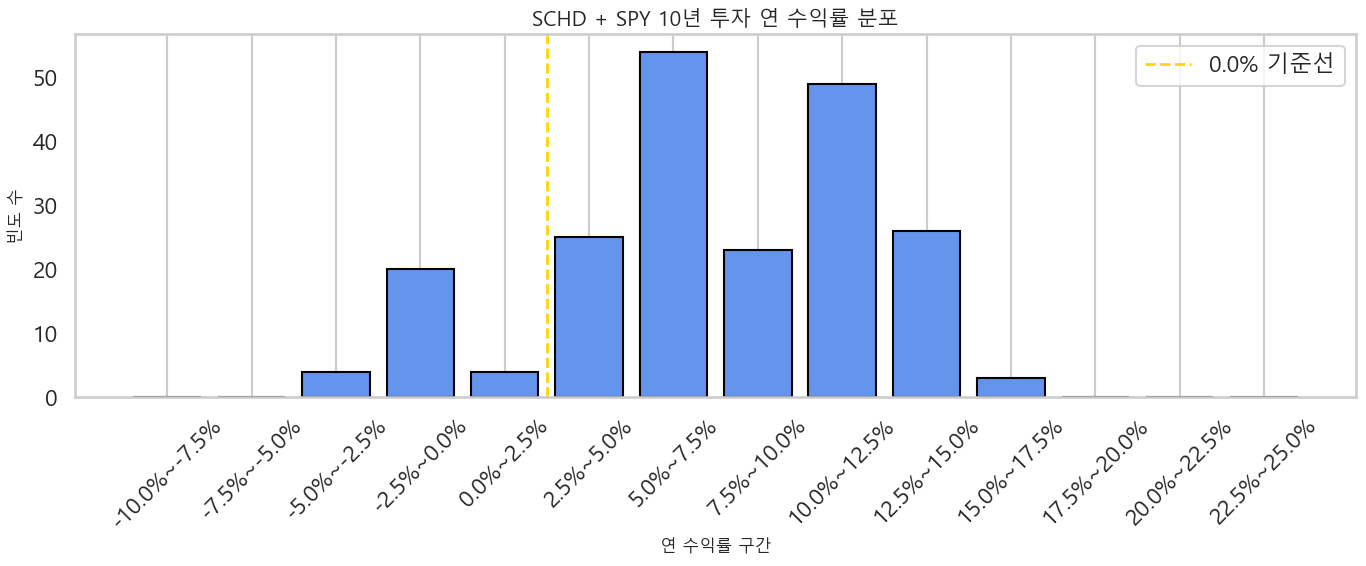

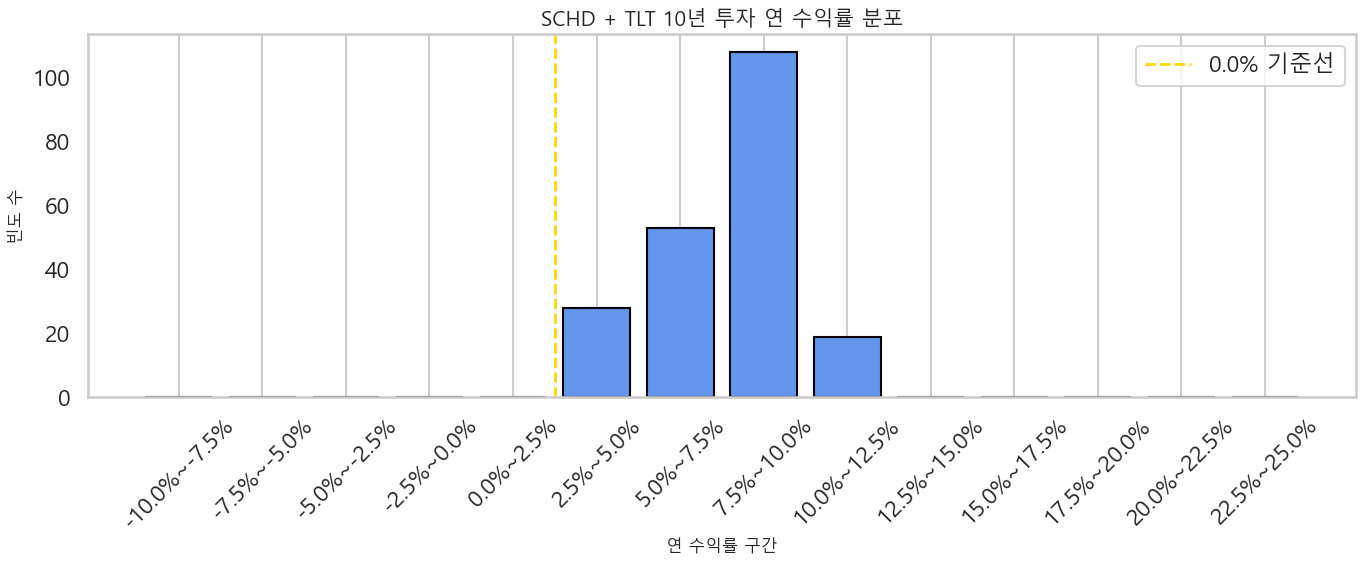

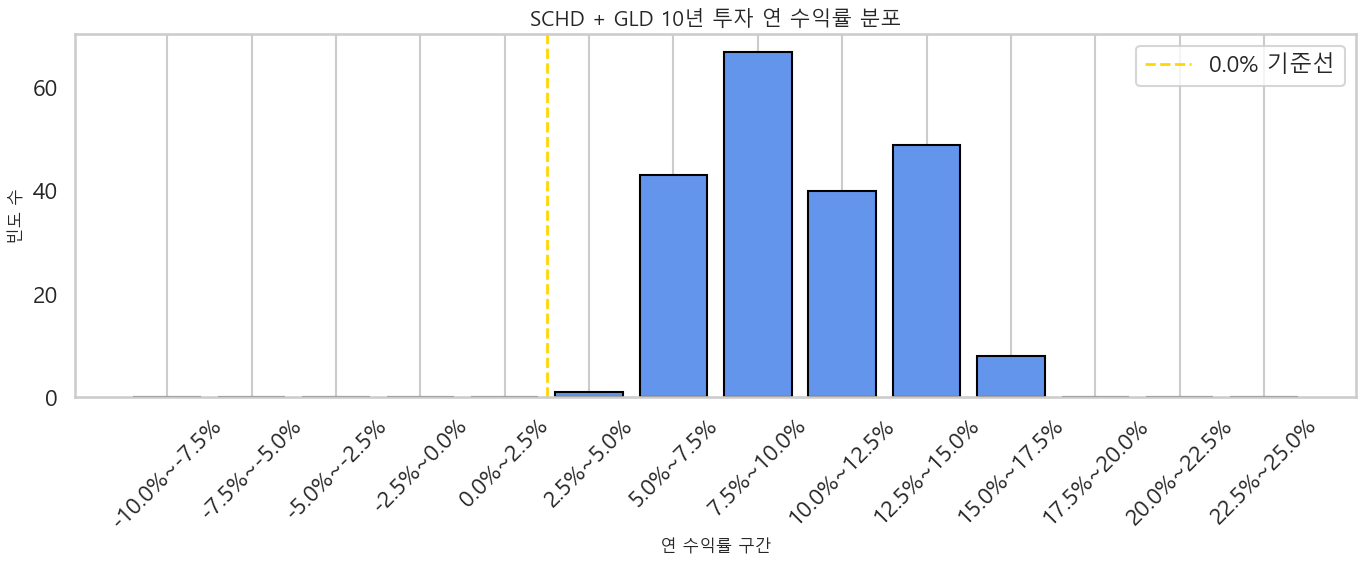

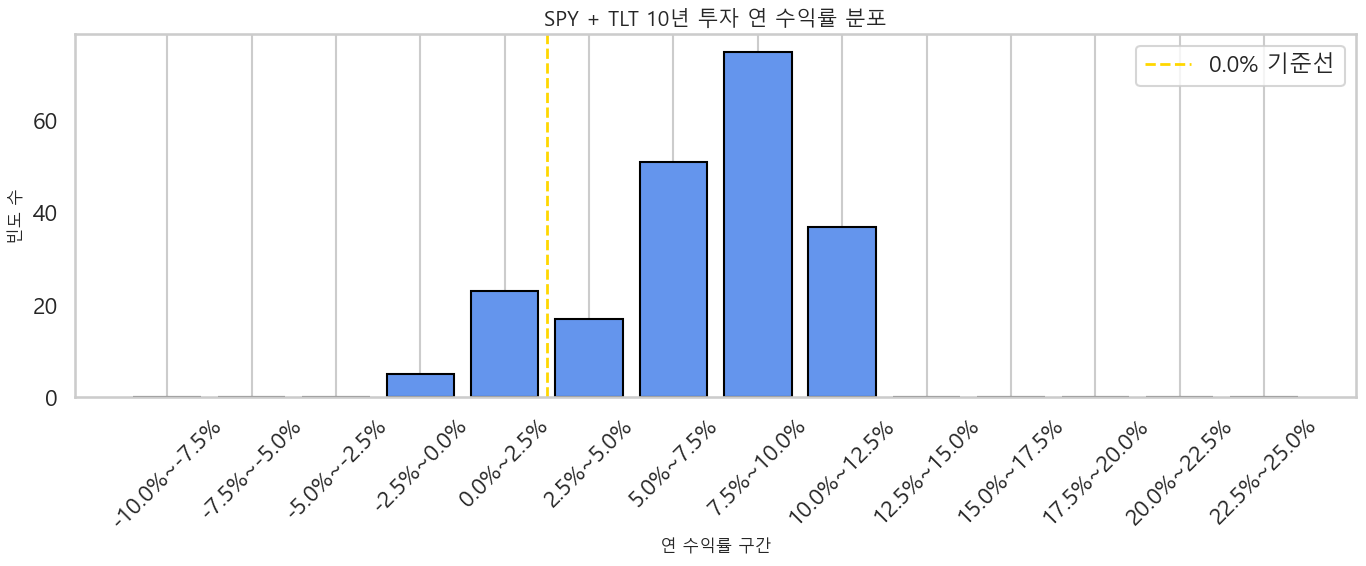

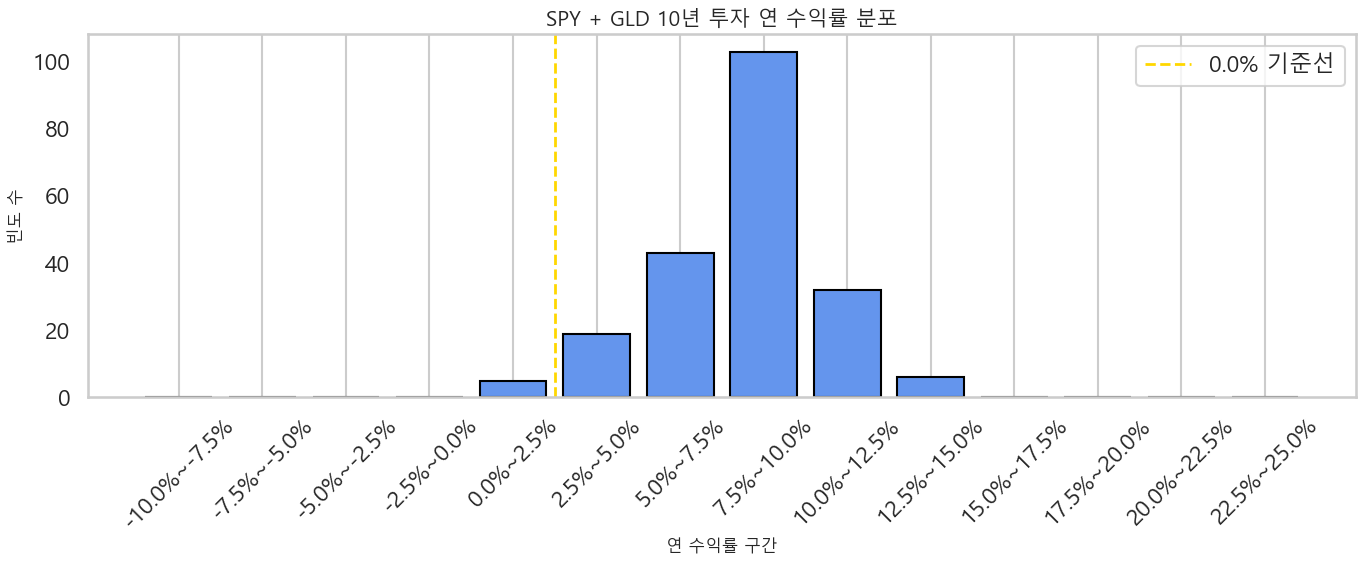

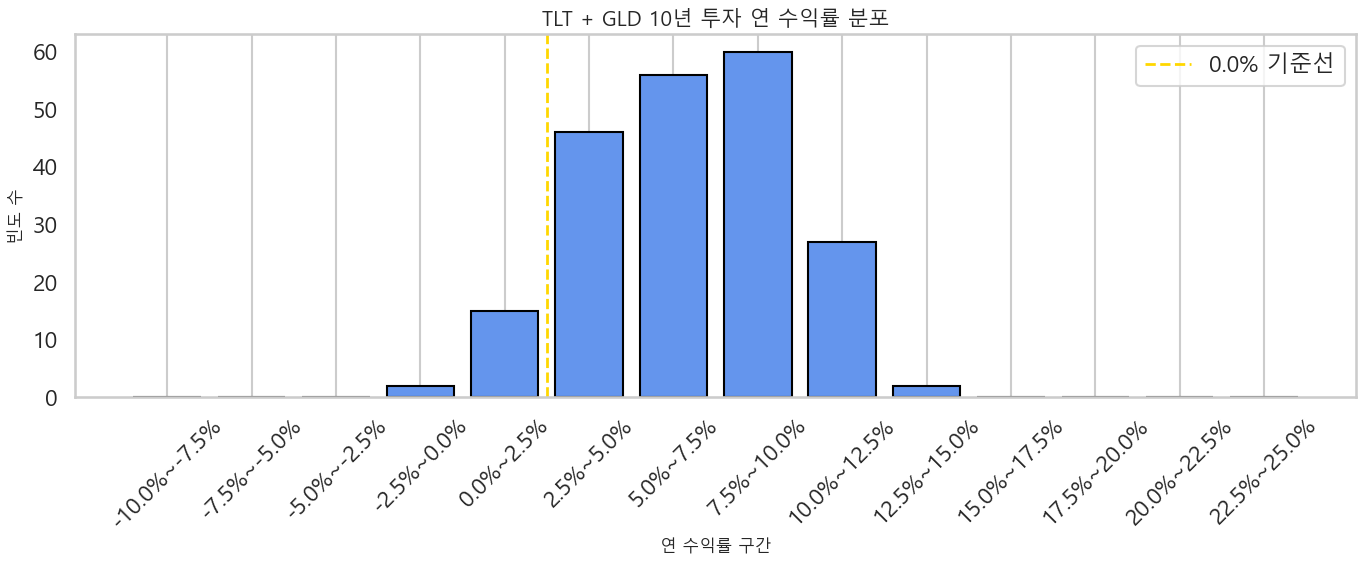

In [8]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <1>에서 indiv_returns_df가 이미 준비되어 있다고 가정
# indiv_returns_df : Date-indexed DataFrame, 컬럼명은 6개 종목명, 값은 월별 수익률

tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 6개 중 2개 조합 생성 (총 15개)
combinations = list(itertools.combinations(tickers, 2))

window = 120  # 10년 (120개월)

for combo in combinations:
    # 1) 조합 종목 월별 수익률 평균(포트폴리오 수익률) 계산
    portfolio_return = indiv_returns_df[list(combo)].mean(axis=1)

    # 2) 10년 단위 연 복리 수익률 계산
    rolling_returns = []
    dates = []
    for i in range(len(portfolio_return) - window):
        window_returns = portfolio_return.iloc[i:i + window]
        total_return = (1 + window_returns).prod()
        annualized_return = total_return ** (1 / 10) - 1  # 연 복리 환산
        rolling_returns.append(annualized_return * 100)
        dates.append(portfolio_return.index[i + window])

    # 3) 수익률 구간 나누기 (2.5% 간격)
    df_roll = pd.DataFrame({'Date': dates, '10Y_Annual_Return (%)': rolling_returns})
    bins = np.arange(-10, 25.1, 2.5)
    labels = [f"{bins[i]:.1f}%~{bins[i+1]:.1f}%" for i in range(len(bins) - 1)]
    df_roll['Range'] = pd.cut(df_roll['10Y_Annual_Return (%)'], bins=bins, labels=labels, right=False)
    counts = df_roll['Range'].value_counts().sort_index()

    # 4) 시각화
    plt.figure(figsize=(14, 6))
    bars = plt.bar(counts.index, counts.values, color='cornflowerblue', edgecolor='black')

    # 0% 기준선 그리기
    zero_index = [i for i, label in enumerate(counts.index) if label.startswith("0.0")]
    if zero_index:
        plt.axvline(x=zero_index[0] + 0.5, color='gold', linestyle='--', linewidth=2, label='0.0% 기준선')

    plt.title(f"{combo[0]} + {combo[1]} 10년 투자 연 수익률 분포", fontsize=15)
    plt.xlabel("연 수익률 구간", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

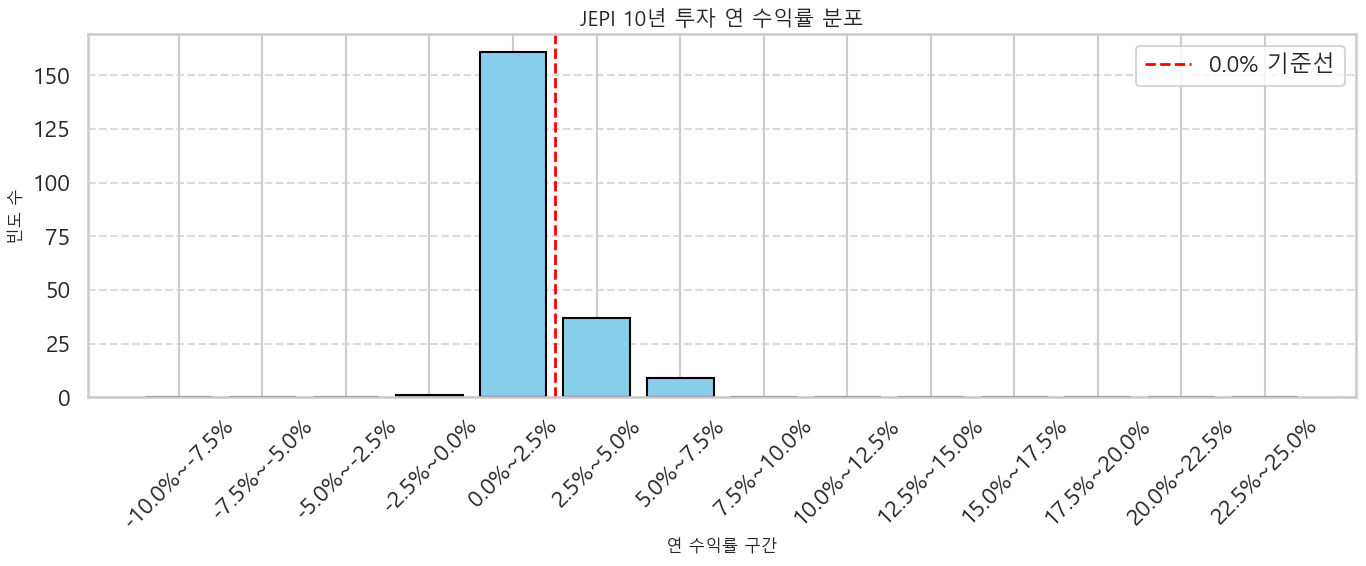

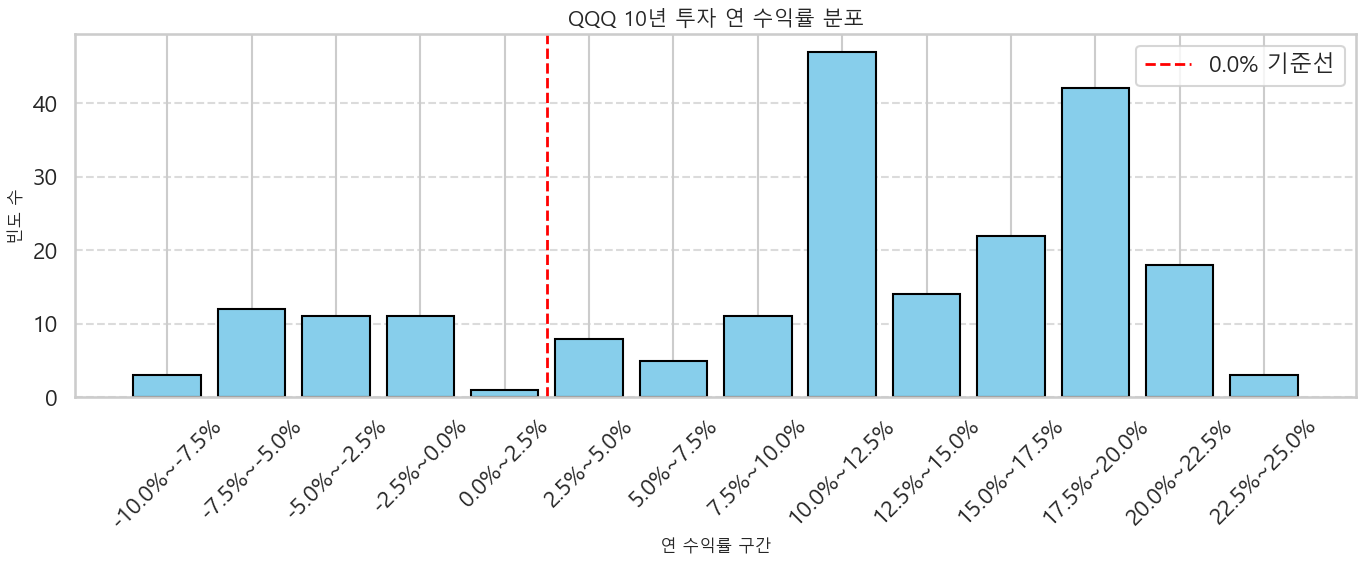

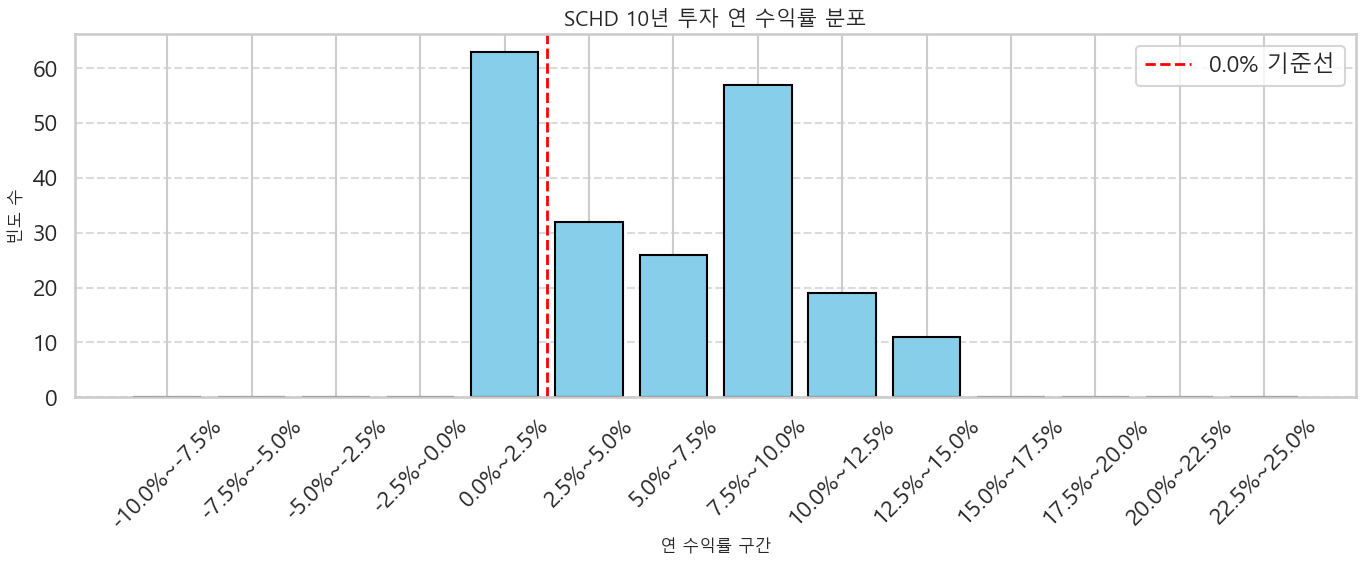

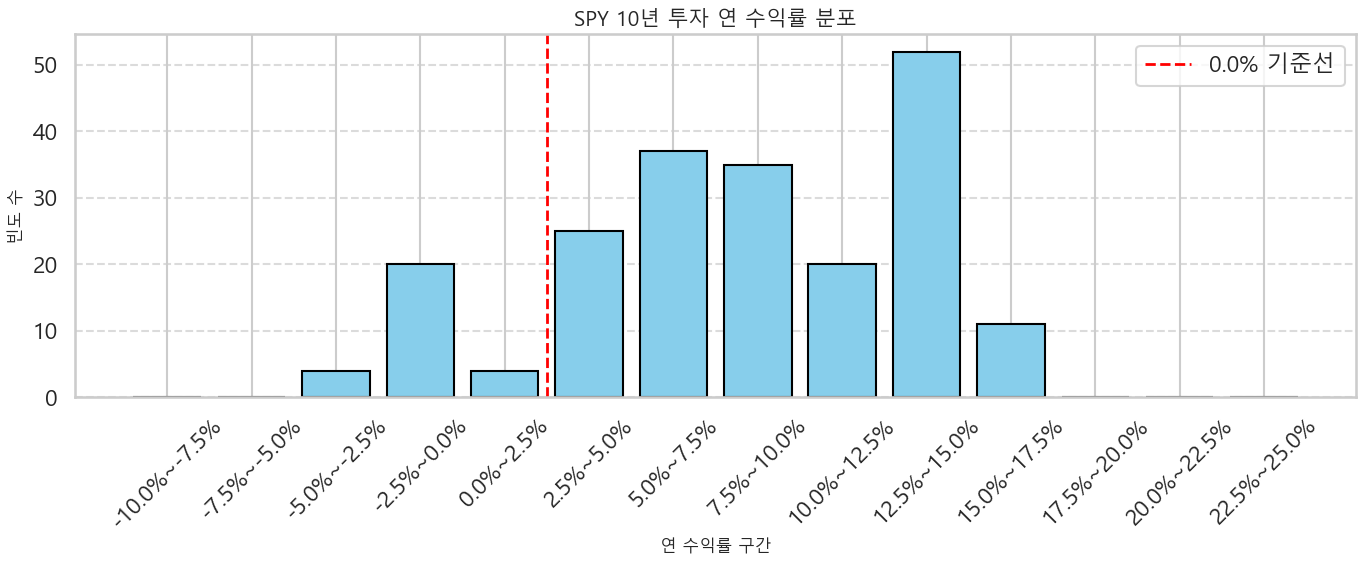

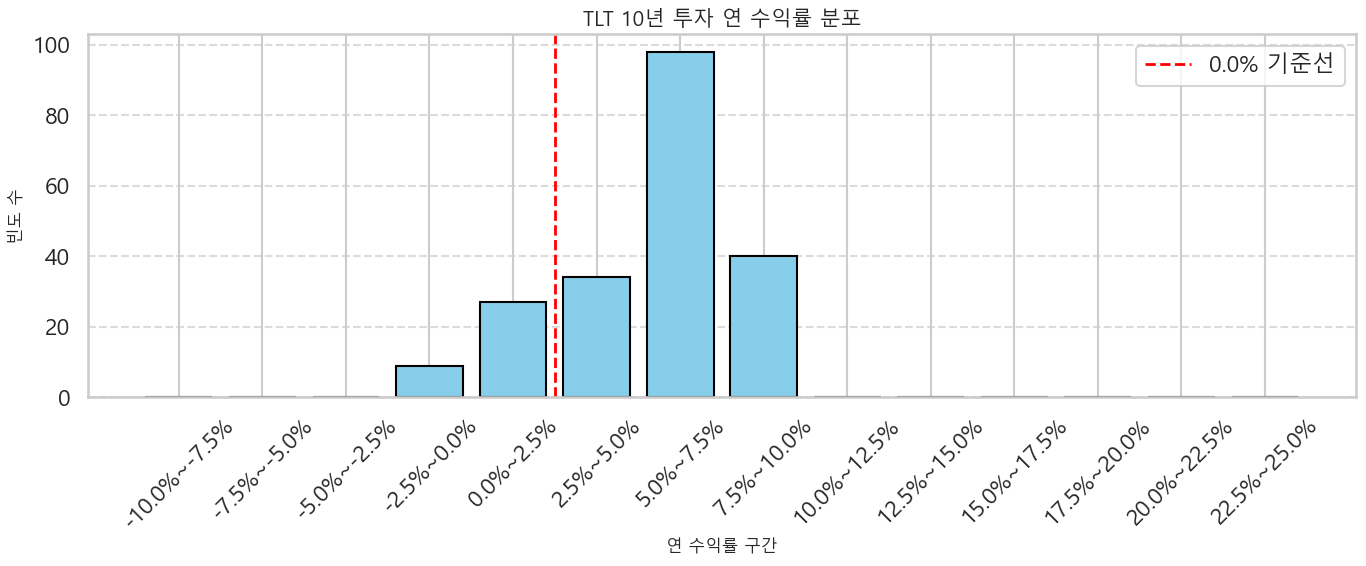

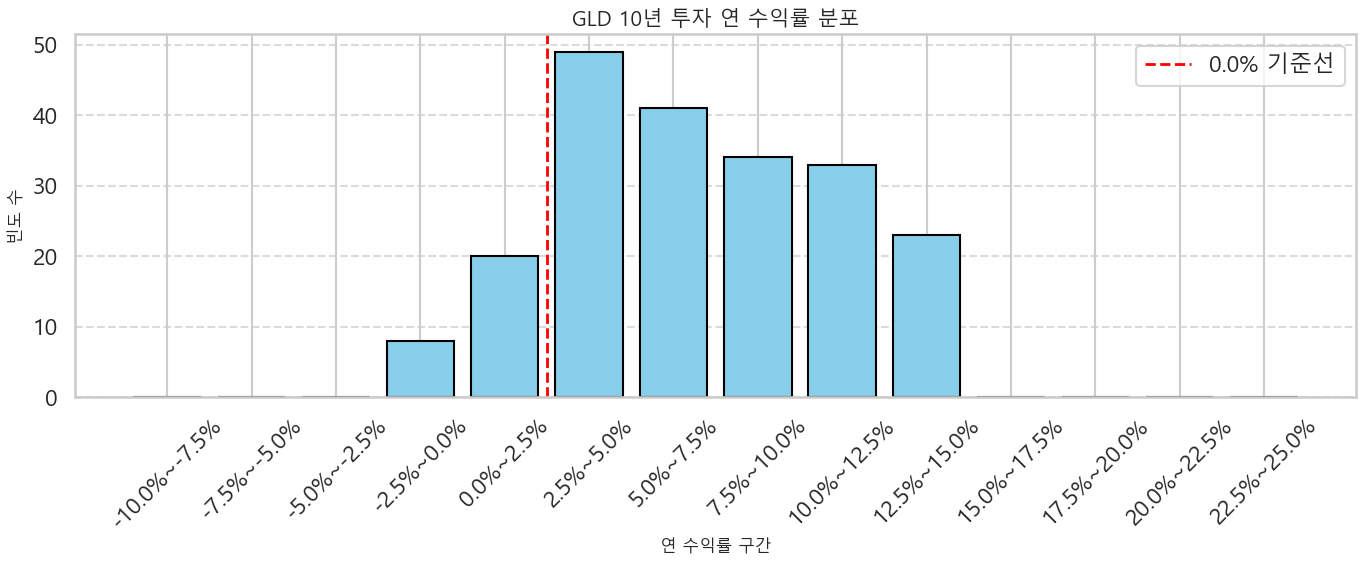

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

window = 120  # 10년 (120개월)

for ticker in tickers:
    # 1) 해당 종목 월별 수익률 시리즈
    returns = indiv_returns_df[ticker]

    # 2) 10년 단위 연 복리 수익률 계산
    rolling_returns = []
    dates = []
    for i in range(len(returns) - window):
        window_returns = returns.iloc[i:i + window]
        total_return = (1 + window_returns).prod()
        annualized_return = total_return ** (1 / 10) - 1
        rolling_returns.append(annualized_return * 100)
        dates.append(returns.index[i + window])

    # 3) 수익률 구간 나누기 (2.5% 간격)
    df_roll = pd.DataFrame({'Date': dates, '10Y_Annual_Return (%)': rolling_returns})
    bins = np.arange(-10, 25.1, 2.5)
    labels = [f"{bins[i]:.1f}%~{bins[i+1]:.1f}%" for i in range(len(bins) - 1)]
    df_roll['Range'] = pd.cut(df_roll['10Y_Annual_Return (%)'], bins=bins, labels=labels, right=False)
    counts = df_roll['Range'].value_counts().sort_index()

    # 4) 시각화
    plt.figure(figsize=(14, 6))
    bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

    # 0% 기준선 표시
    zero_index = [i for i, label in enumerate(counts.index) if label.startswith("0.0")]
    if zero_index:
        plt.axvline(x=zero_index[0] + 0.5, color='red', linestyle='--', linewidth=2, label='0.0% 기준선')

    plt.title(f"{ticker} 10년 투자 연 수익률 분포", fontsize=15)
    plt.xlabel("연 수익률 구간", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()